# 21강 워드 임베딩 (2) Word2Vec 실습 3회차: 단어 임베딩 모델을 활용한 NSMC 감정분석

2025-12-03

## 0. 환경 설정

In [1]:
# 필요한 라이브러리 설치
# %pip install datasets scikit-learn pandas numpy matplotlib seaborn
# %pip install gensim

In [2]:
# 한글 폰트 파일 다운로드
# !mkdir -p ../fonts
# !wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip -O ../fonts/NotoSansCJKkr-hinted.zip
# !unzip ../fonts/NotoSansCJKkr-hinted.zip -d ../fonts
# !rm ../fonts/NotoSansCJKkr-hinted.zip

In [3]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, load_from_disk
from collections import Counter
from tqdm import tqdm
from gensim.models import Word2Vec, FastText
from konlpy.tag import Okt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# 한글 폰트 설정
import matplotlib.font_manager as fm

# 한글 폰트 설정 (matplotlib)
font_dir = ['../fonts']
for font in fm.findSystemFonts(font_dir):
    fm.fontManager.addfont(font)

plt.rcParams['font.family'] = 'Noto Sans CJK KR'
plt.rcParams['axes.unicode_minus'] = False

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

print("라이브러리 로드 완료!")

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


라이브러리 로드 완료!


## 1. 코퍼스 로드

In [4]:
data_path = '../data/nsmc-okt'
dataset = load_from_disk(data_path)

train_corpus = dataset['train']['morphs']
test_corpus = dataset['test']['morphs']

## 2. 워드 임베딩을 사용한 문서 벡터화

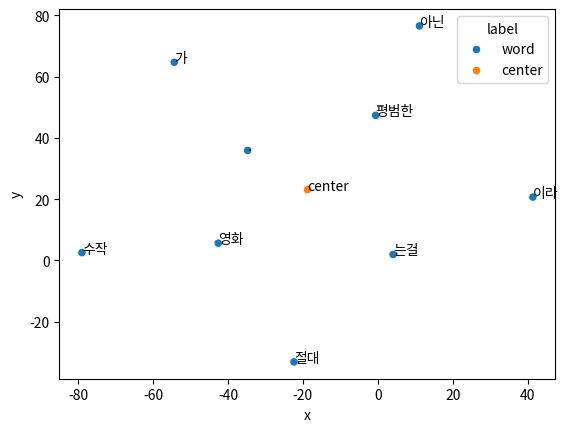

In [5]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=3, random_state=1044)

model_path = f'../models/nsmc_word2vec_sg.model'
model = Word2Vec.load(model_path)
vocab = model.wv.index_to_key

morphs = train_corpus[23]
morphs = list(set(morphs).intersection(vocab))
vectors = model.wv[morphs] 
center = vectors.mean(axis=0)

df = pd.DataFrame(
    tsne.fit_transform(np.concat([vectors, [center]])),
    columns = ('x', 'y')
)

df['word'] = morphs + ['center']
df['label'] = ['word'] * len(vectors) + ['center']

ax = sns.scatterplot(df, x='x', y='y', hue='label')
for _, row in df.iterrows():
    ax.annotate(row['word'], (row['x'], row['y']))


In [6]:
def get_centroid(morphs, model, fasttext=False, vocab=None):
    if not fasttext:
        morphs = list(set(morphs).intersection(vocab)) # faster than list comprehension
    if morphs:
        centroid = model.wv[morphs].mean(axis=0)
    else:
        centroid = np.zeros(model.wv.vector_size)
    return centroid

## 4. 로지스틱 회귀분석 결과

In [7]:
tqdm.pandas()

y_train = np.array(dataset['train']['label'])
y_test = np.array(dataset['test']['label'])

classes = ('FastText', 'Word2Vec',)
algorithms = ('SG', )  # ('CBOW', 'SG')

for class_ in classes:
    for algorithm in algorithms:
        print(f'{class_} {algorithm} 모델 로드...')
        model_path = f'../models/nsmc_{class_.lower()}_{algorithm.lower()}.model'
        model = eval(class_).load(model_path)

        fasttext = (class_ == 'FastText')
        vocab = None if fasttext else model.wv.index_to_key
        print('중심점 계산 중...')
        X_train = np.vstack(
            [get_centroid(morphs, model, fasttext, vocab) for morphs in tqdm(dataset['train']['morphs'])]
        )
        X_test = np.vstack(
            [get_centroid(morphs, model, fasttext, vocab) for morphs in tqdm(dataset['test']['morphs'])]
        )

        classifier = LogisticRegression(
            max_iter=1000,  # 충분한 반복 횟수
            random_state=1046,
            n_jobs=-1  # 모든 CPU 코어 사용
        )
        print('로지스틱 회귀 모델 훈련 중...')
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        print('정확도:', accuracy_score(y_test, y_pred))
        print('=' * 20)


FastText SG 모델 로드...
중심점 계산 중...


100%|██████████| 50000/50000 [00:05<00:00, 8745.43it/s]


로지스틱 회귀 모델 훈련 중...
정확도: 0.82854
Word2Vec SG 모델 로드...
중심점 계산 중...


100%|██████████| 50000/50000 [00:18<00:00, 2638.64it/s]


로지스틱 회귀 모델 훈련 중...
정확도: 0.8221
